# Chapter7. 합성곱 신경망(CNN)

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container{width:100%!important;}</style>"))

In [2]:
from IPython.display import Image
import numpy as np

## 7.1 전체 구조

#### 완전연결 계층(Affine 계층)의 예

**완전연결**: 인접하는 계층의 모든 뉴런과 결합

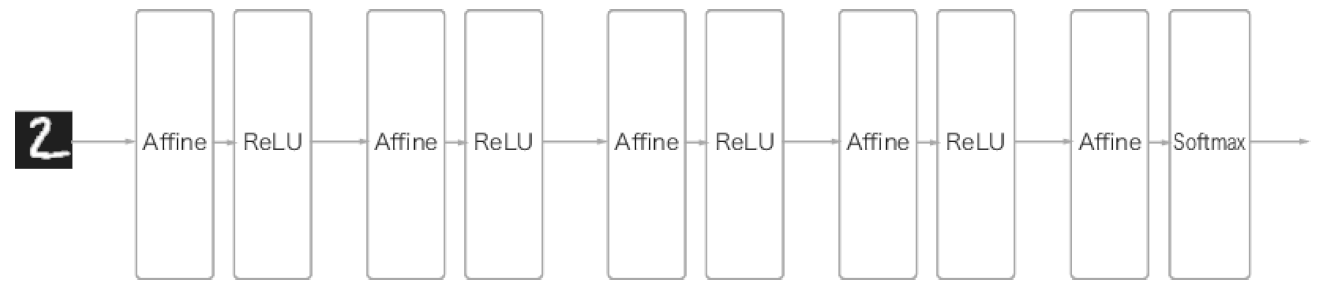

In [3]:
Image("image/fig 7-1.png")

완전연결 신경망은 Affine 계층 뒤에 활성화 함수를 갖는 ReLU 계층(혹은 Sigmoid 계층)이 이어짐

#### CNN으로 이루어진 네트워크의 예

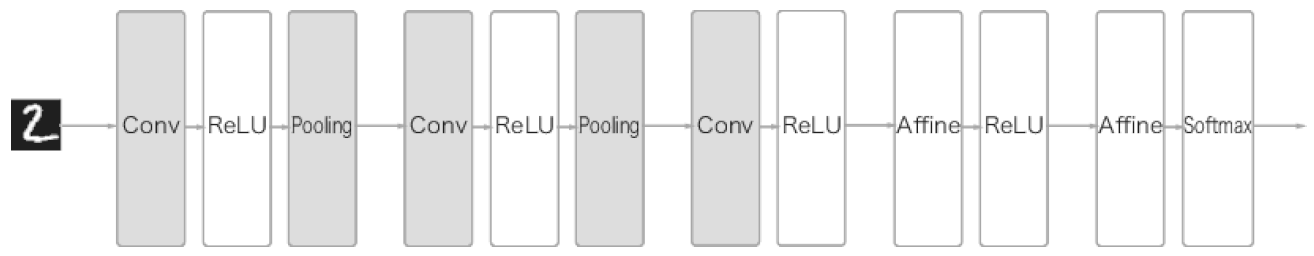

In [4]:
Image("image/fig 7-2.png")

- CNN에서는 새로운 합성곱계층(Conv)과 풀링계층(Pooling)이 추가됨 (-> 풀링 계층은 생략하기도 함!)
- 지금까지의 Affine-ReLU 연결이 Conv-ReLU-(Pooling)으로 바뀌는 형태

## 7.2 합성곱 계층

### 7.2.1 완전연결 계층과 CNN

- 인접하는 계층의 뉴런이 모두 연결되고 출력의 수는 임의로 정할 수 있음
- 데이터의 형상이 무시된다는 문제점이 있음 (-> MNIST의 경우에도 3차원 형상의 이미지를 평평한 1차원 데이터로 바꾸어 학습시켰음)
- 합성곱 계층의 경우 **형상을 유지할 수 있음** -> 이미지를 3차원 데이터로 입력받아 형태를 유지하며 다음 계층으로 전달
- CNN에서 합성곱 계층의 입출력 데이터 = **'특징맵'**

# 7.2.2 합성곱 연산

필터의 윈도우를 일정간격으로 이동해가며 입력데이터에 적용하고, 입력과 필터에서 대응하는 원소끼리 곱한 후 그 총합을 구함

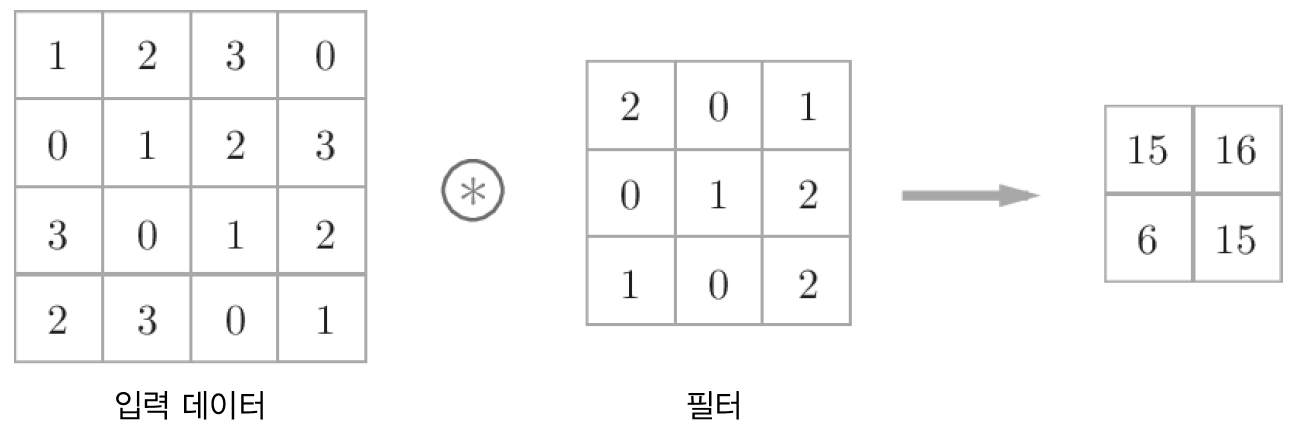

In [6]:
Image("image/fig 7-3.png")

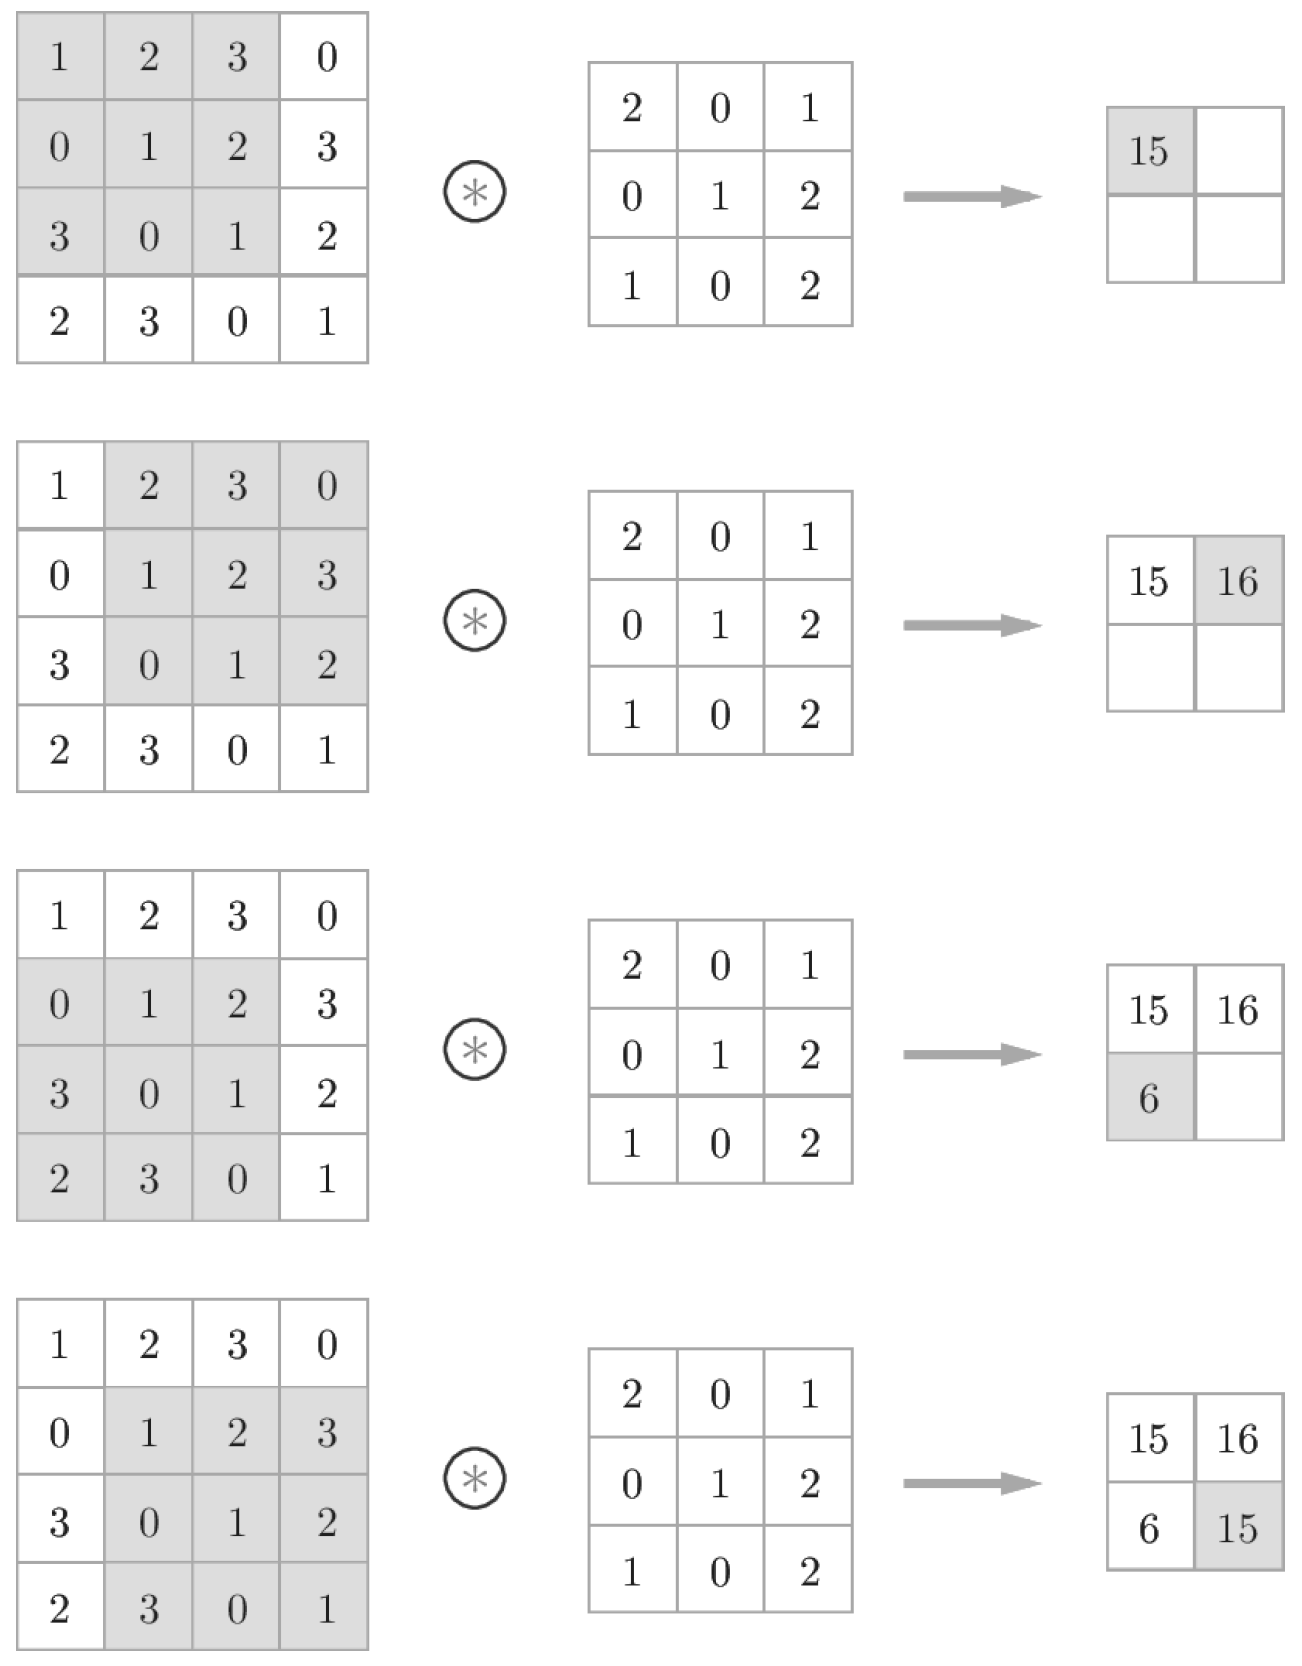

In [7]:
Image("image/fig 7-4.png")

#### 편향까지 반영한 합성곱 연산

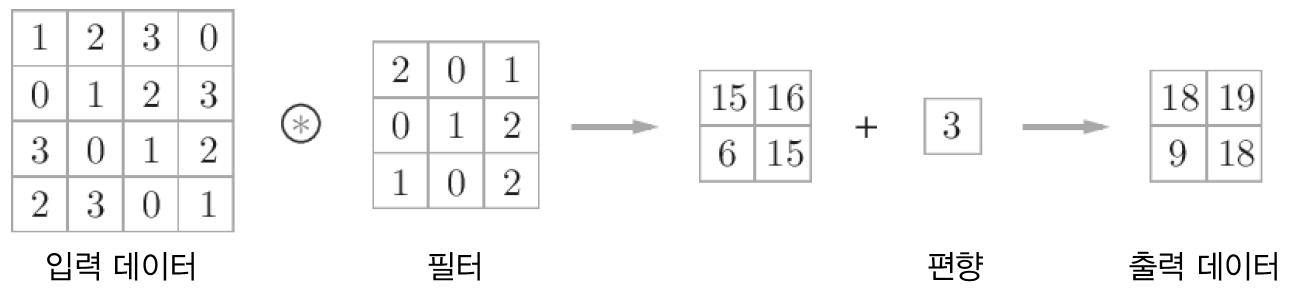

In [8]:
Image("image/fig 7-5.png")

### 7.2.3 패딩

합성곱 연산을 수행하기 전에 데이터 주변을 특정 값으로 채우는 과정

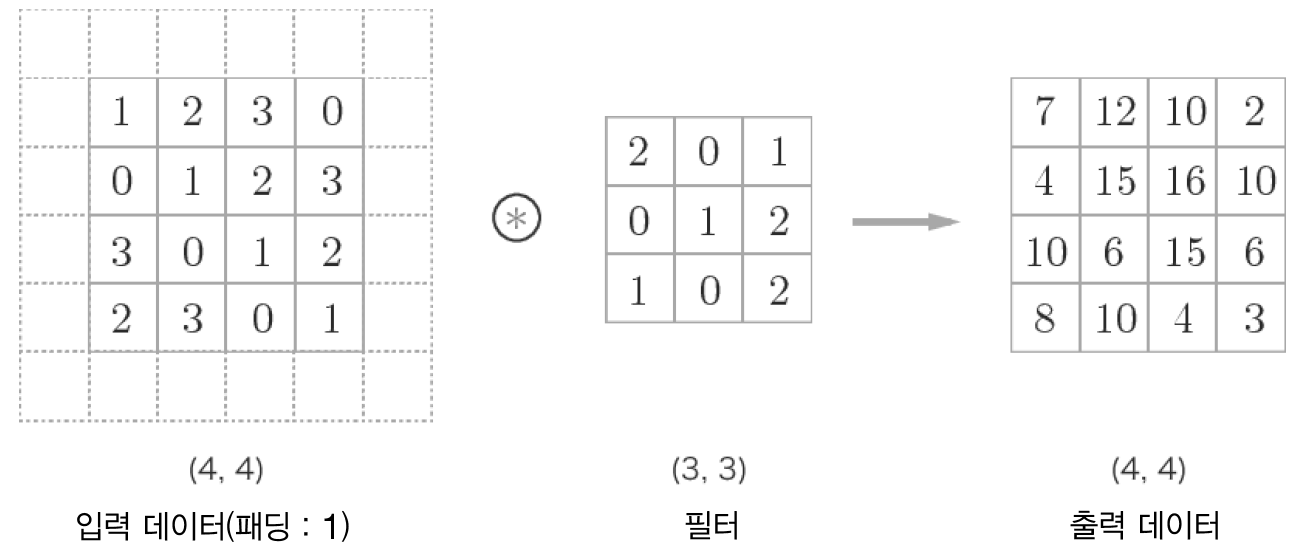

In [9]:
Image("image/fig 7-6.png")

### 7.2.4 스트라이드

**스트라이드**: 필터를 적용하는 위치의 간격

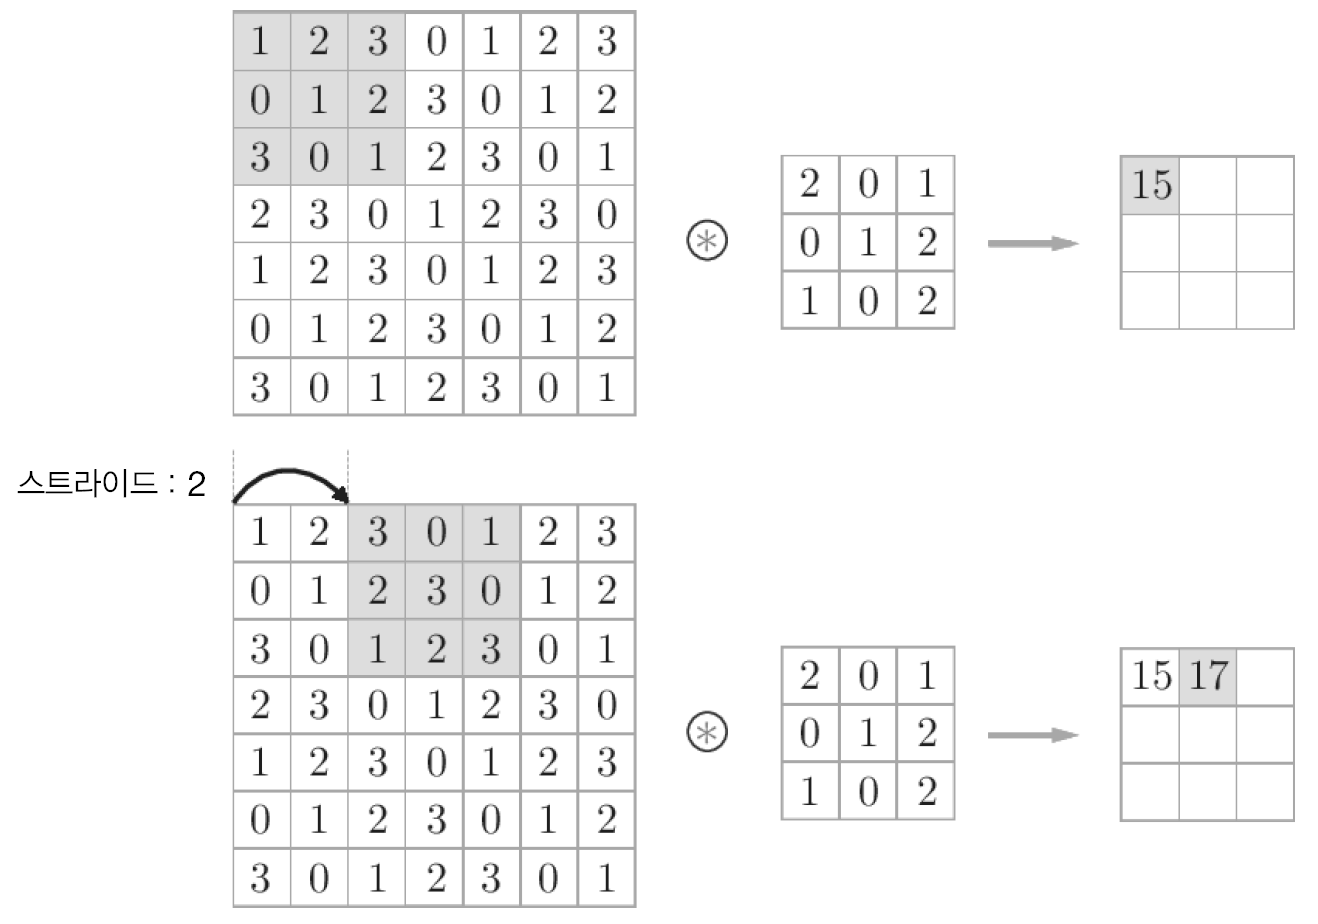

In [10]:
Image("image/fig 7-7.png")

**스트라이드를 키우면 출력의 크기는 작아짐!**

#### 출력크기 계산
입력크기=(H,W), 필터크기=(FH, FW), 출력크기=(OH, OW), 패딩=P, 스트라이드=S라 하면

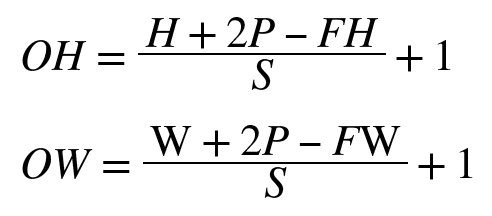

In [11]:
Image("image/e 7.1.png")

단, 출력크기가 정수가 되도록 맞춰주어야 함!

### 7.2.5 3차원 데이터의 합성곱 연산

입력 데이터와 필터의 **합성곱 연산을 채널마다 수행**하고, **그 결과를 더해서** 하나의 출력을 얻는다! </br>
단, **필터의 채널 수 = 입력 데이터의 채널 수**

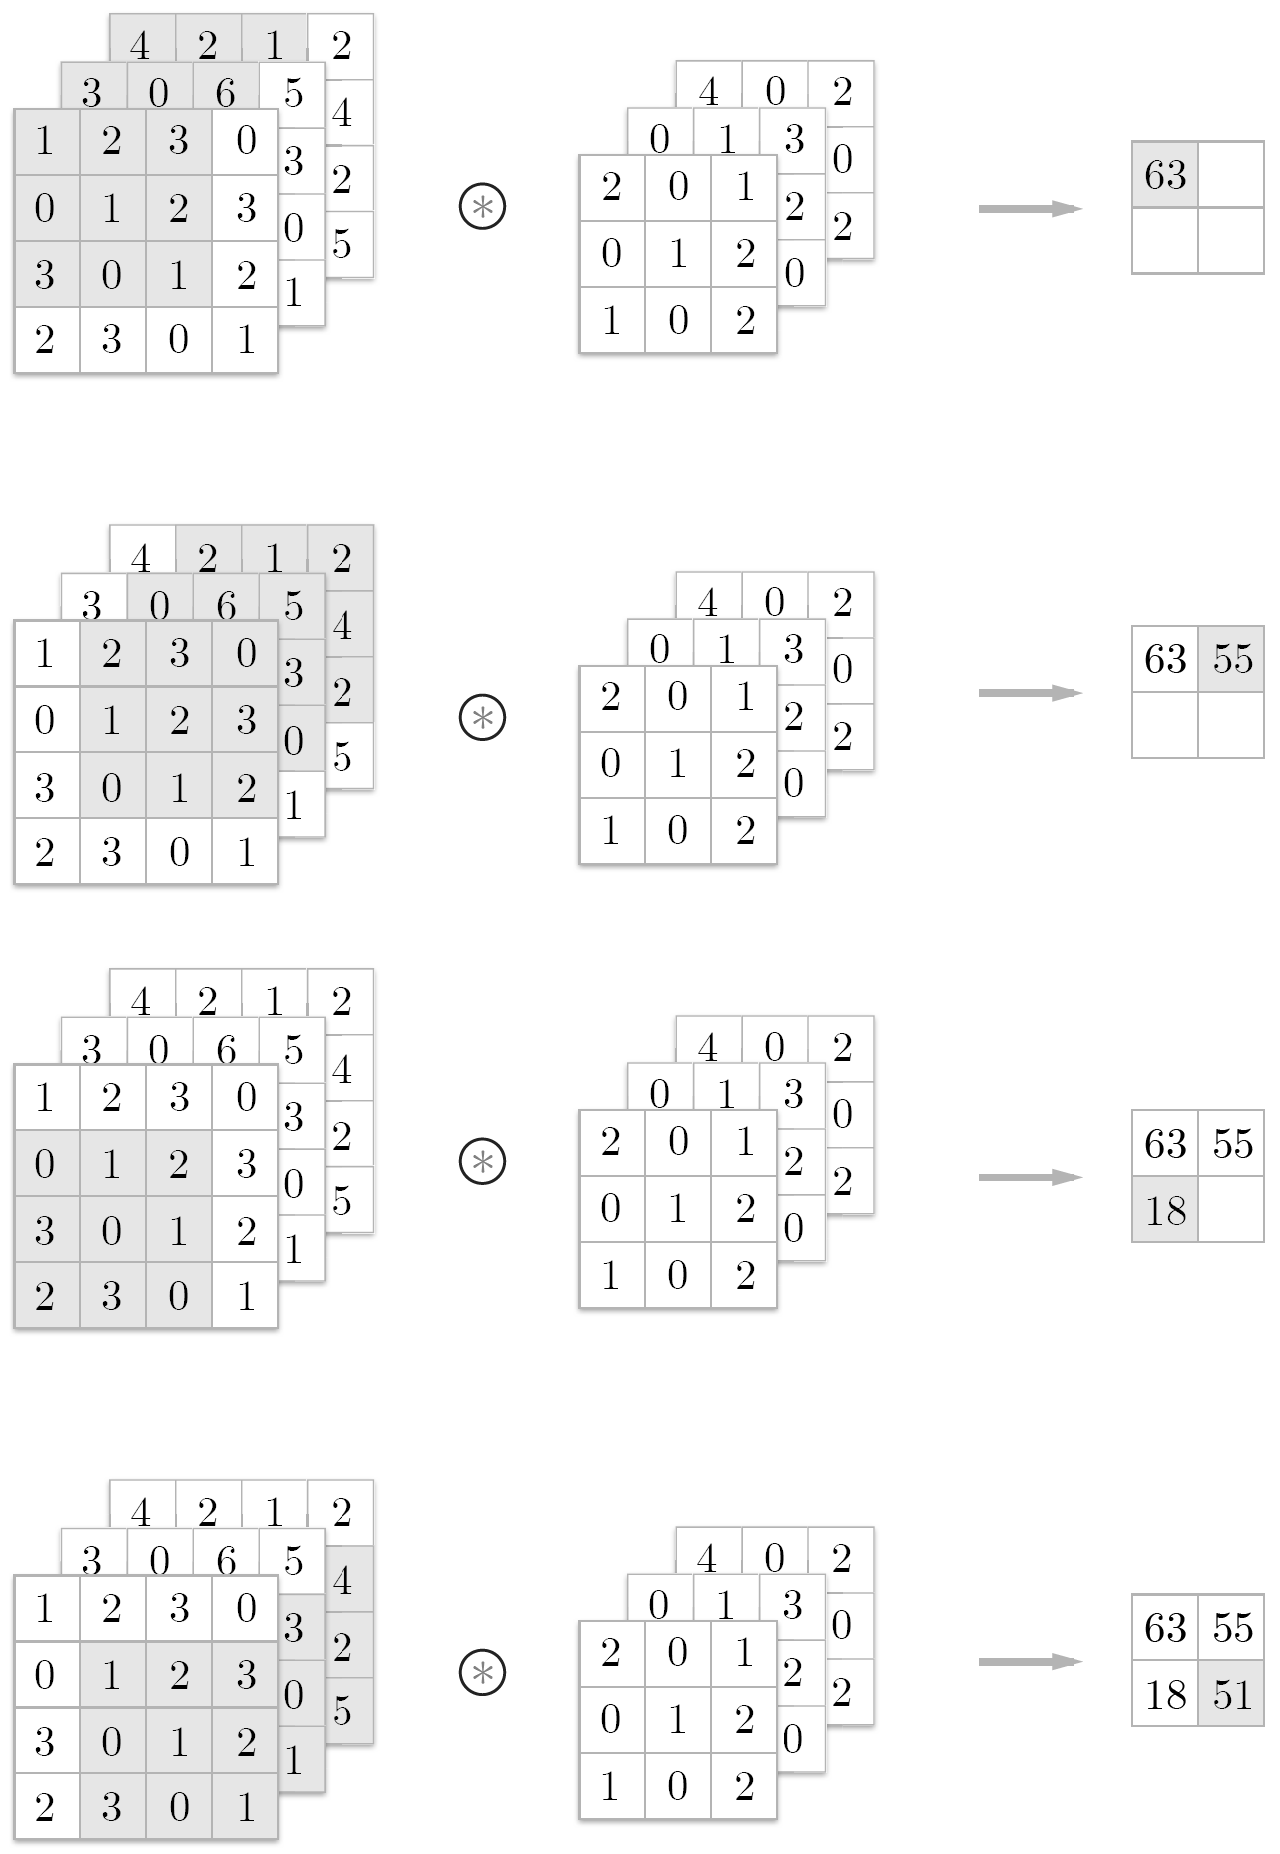

In [12]:
Image("image/fig 7-9.png")

### 7.2.6 블록으로 생각하기

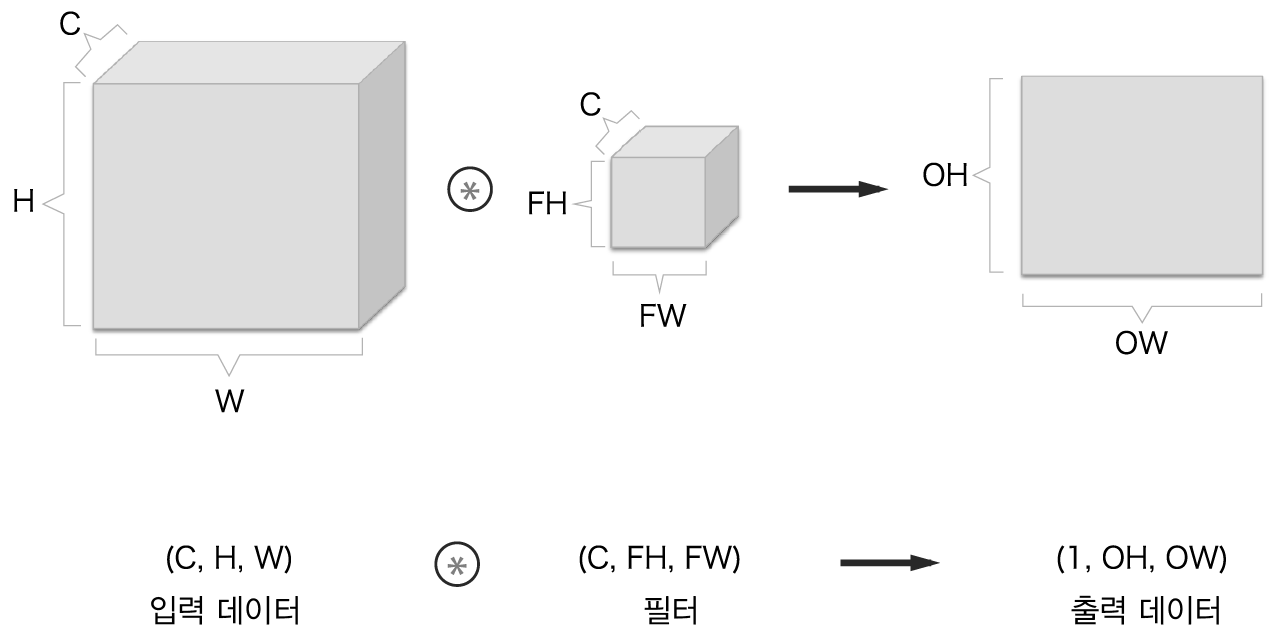

In [13]:
Image("image/fig 7-10.png")

#### 합성곱 연산의 출력으로 다수의 채널을 내보내려면? -> 필터를 여러 세트 사용하자!

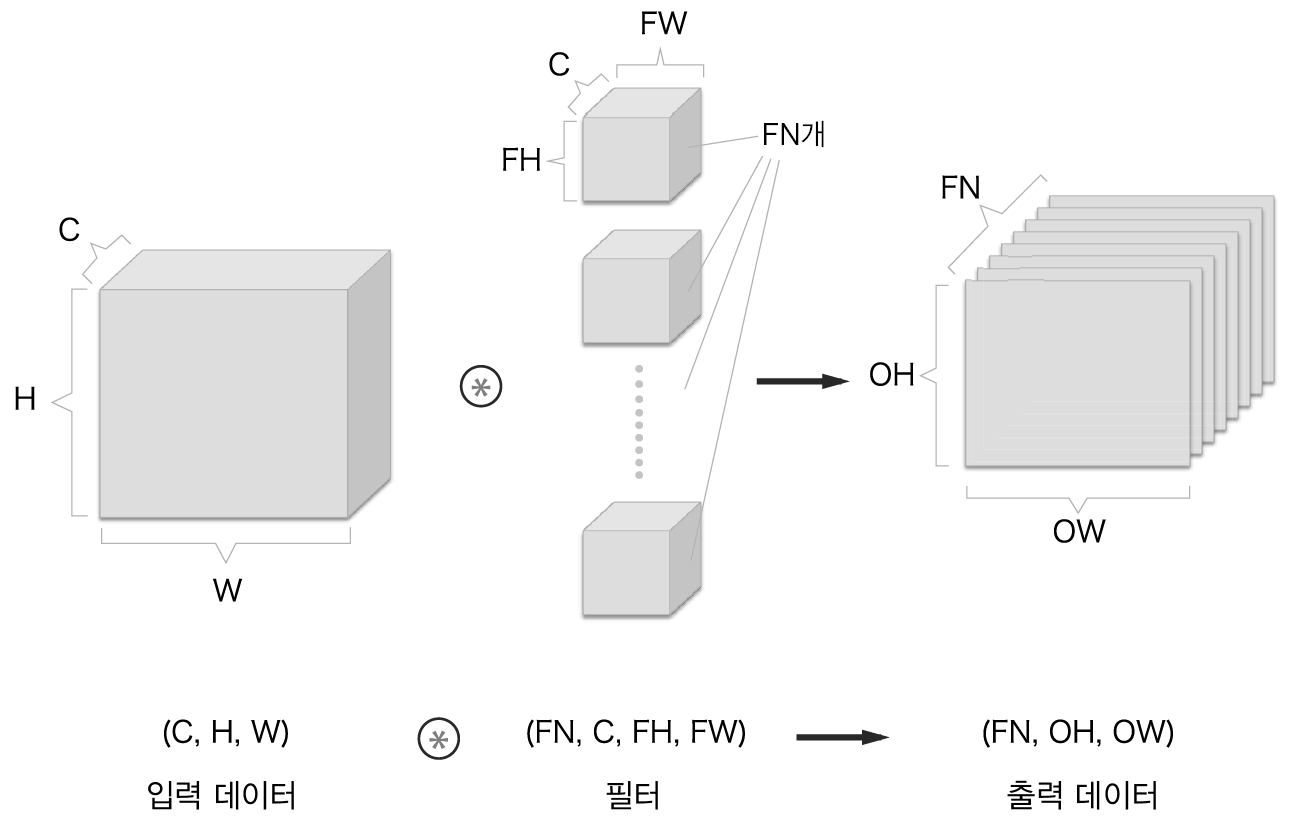

In [14]:
Image("image/fig 7-11.png")

## 7.3 풀링 계층

가로, 세로 방향의 공간을 줄이는 연산

**최대풀링**: 대상영역 안에서 최대 값을 구하는 연산 (-> 대상 영역이 nxn 형태인 경우 스트라이드는 n으로 설정) 

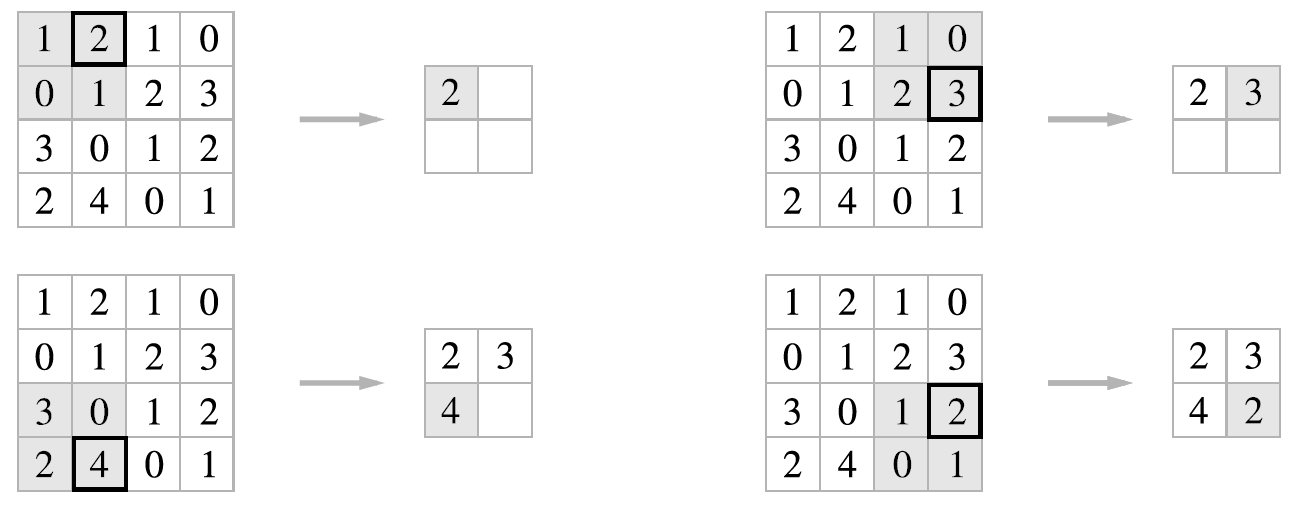

In [15]:
Image("image/fig 7-14.png")

+) **평균풀링**의 경우 대상영역의 평균을 계산

### 7.3.1 풀링 계층의 특징

- 학습해야 할 매개변수가 없음
- 채널 수가 변하지 않음 (채널마다 독립적으로 계산)
- 입력의 변화에 영향을 적게 받음

## 7.4 합성곱/풀링 계층 구현

### 7.4.3 합성곱 계층 구현하기

**im2col**: 입력 데이터를 필터링하기 좋게 전개하는 함수 (필터를 적용하는 영역을 한 줄로 늘어놓는다!)</br>
필터를 세로로 1열로 전개한 후 im2col이 전개한 데이터와 행렬곱 계산, 마지막으로 출력 데이터 reshape

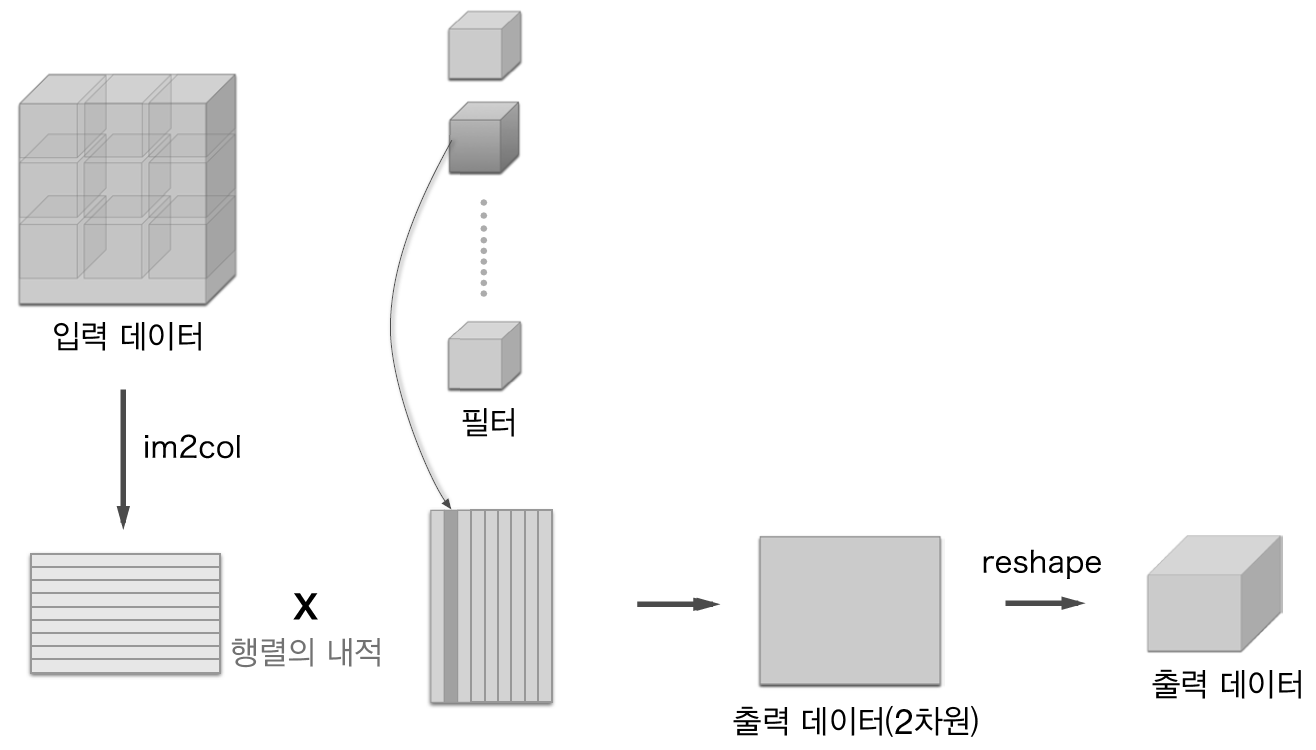

In [16]:
Image("image/fig 7-19.png")

In [18]:
import sys, os
sys.path.append(os.pardir)
from common.util import im2col

x1 = np.random.rand(1,3,7,7) # 데이터수, 채널수, 높이, 너비
col1 = im2col(x1,5,5,stride=1, pad=0) # 입력데이터, 필터높이, 필터너비, 스트라이드, 패딩
print(col1.shape)

x2 = np.random.rand(10,3,7,7) # 데이터 10개
col2 = im2col(x2,5,5,stride=1, pad=0) 
print(col2.shape)

(9, 75)
(90, 75)


->단, 입력데이터는 (데이터수, 채널수, 높이, 너비)의 4차원 배열

#### 구현

In [19]:
class Convolution:
    
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T
        out = np.dot(col, col_W) + self.b
        
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)


        return out

### 7.4.4 풀링 계층 구현하기

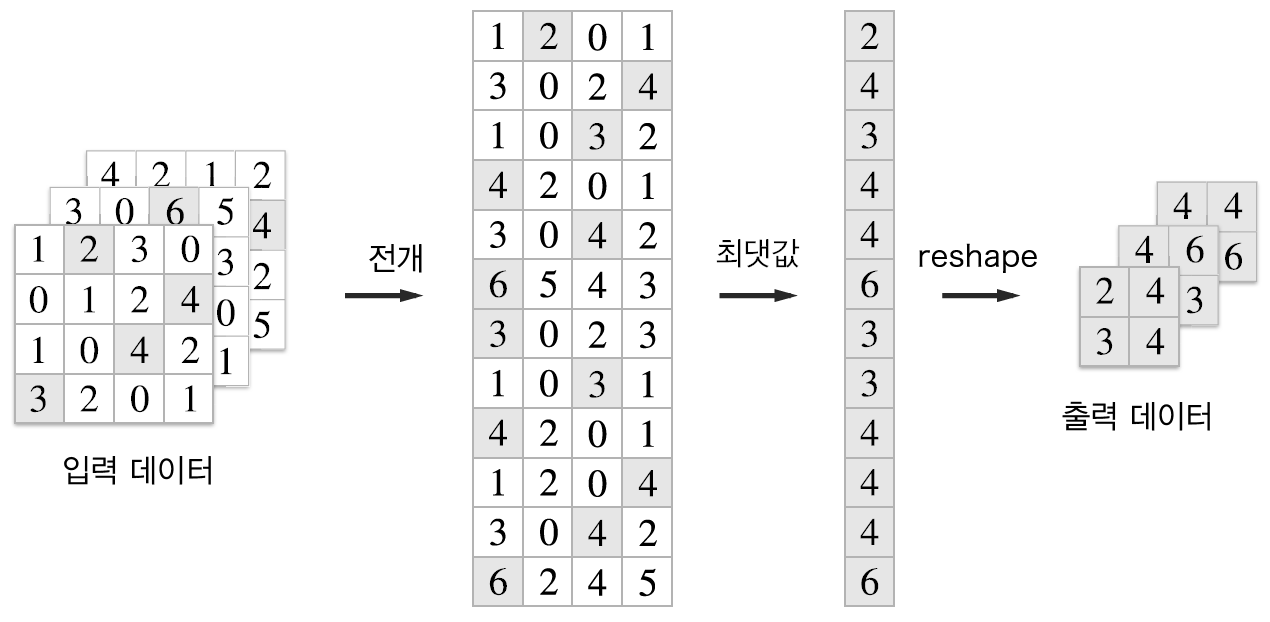

In [20]:
Image("image/fig 7-22.png")

In [21]:
class Pooling:
    
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad


    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        # 입력 데이터 전개
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)
        
        # 행별 최댓값
        arg_max = np.argmax(col, axis=1)
        
        # 적절한 모양으로 reshape
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)


        return out

## 7.5 CNN 구현하기

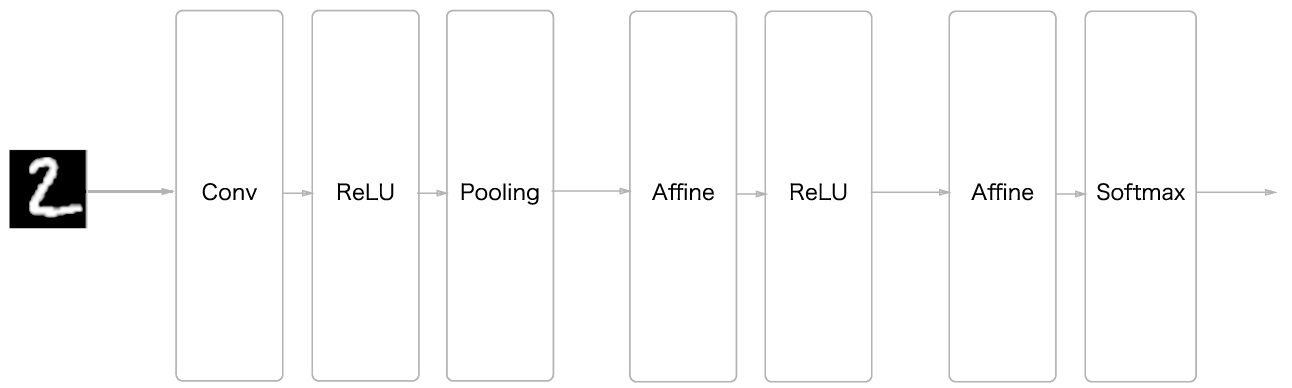

In [22]:
Image("image/fig 7-23.png")

위 그림을 SimpleConvNet이라는 이름의 클래스로 구현해보자!

In [24]:
import sys, os
sys.path.append(os.pardir)
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:

    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

        
        
    def predict(self, x):
        
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    
    
    def loss(self, x, t):
        
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    
    
    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    

    def gradient(self, x, t):

        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads